In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')

## EDA

In [28]:
df = pd.read_csv('data.csv')
df=df.drop(['Unnamed: 0'],axis=1)
df['Date'] = pd.to_datetime(df['Date'])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           365 non-null    datetime64[ns]
 1   Receipt_Count  365 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB
None


,Date,Receipt_Count
0,2021-01-01,7564766
1,2021-01-02,7455524
2,2021-01-03,7095414
3,2021-01-04,7666163
4,2021-01-05,7771289


In [27]:
df.isnull().sum()

Date             0
Receipt_Count    0
dtype: int64

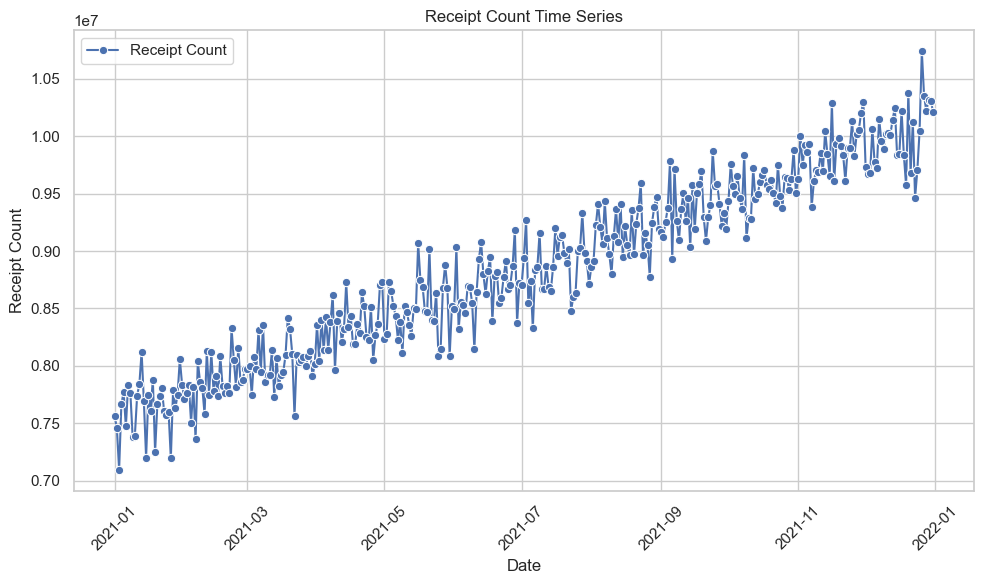

In [31]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(x='Date', y='Receipt_Count', data=df, marker='o', color='b', label='Receipt Count')

plt.xlabel('Date')
plt.ylabel('Receipt Count')
plt.title('Receipt Count Time Series')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

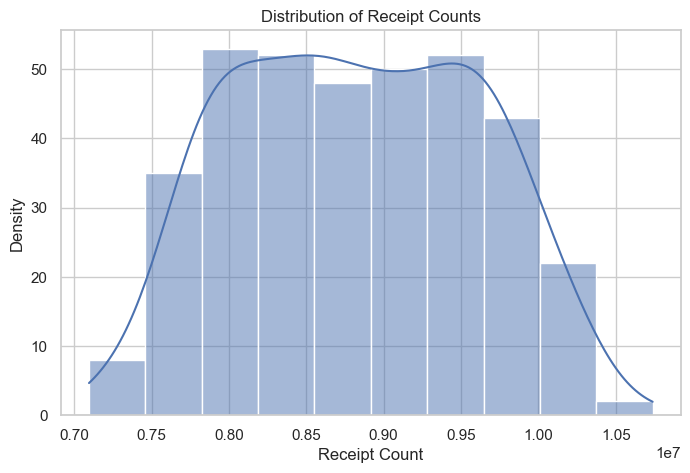

In [32]:
# Distribution plot
plt.figure(figsize=(8, 5))
sns.histplot(df['Receipt_Count'], kde=True)
plt.title('Distribution of Receipt Counts')
plt.xlabel('Receipt Count')
plt.ylabel('Density')
plt.show()

In [33]:
# Extract day, month and year from the Date column
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Day'] = df['Date'].dt.year
df['Weekday'] = df['Date'].dt.weekday

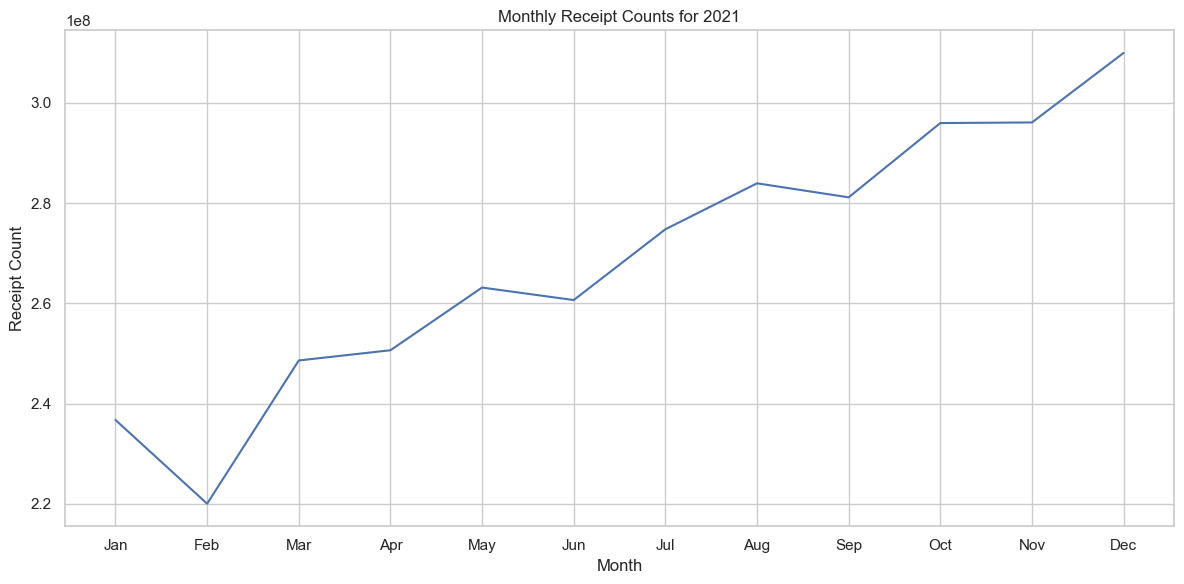

In [34]:
# Aggregating the receipt counts by month
monthly_receipts = df.groupby('Month')['Receipt_Count'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='Receipt_Count', data=monthly_receipts, palette='viridis')
plt.title('Monthly Receipt Counts for 2021')
plt.xlabel('Month')
plt.ylabel('Receipt Count')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

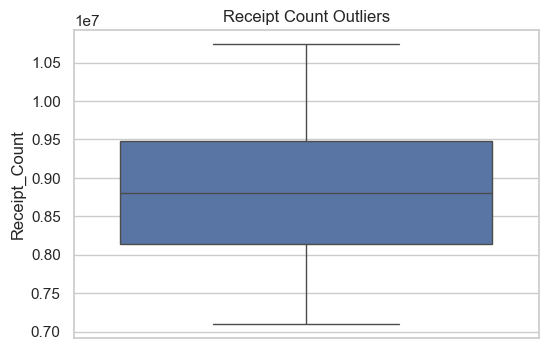

In [35]:
# Box plot to identify outliers
plt.figure(figsize=(6, 4))
sns.boxplot(df['Receipt_Count'])
plt.title('Receipt Count Outliers')
plt.show()

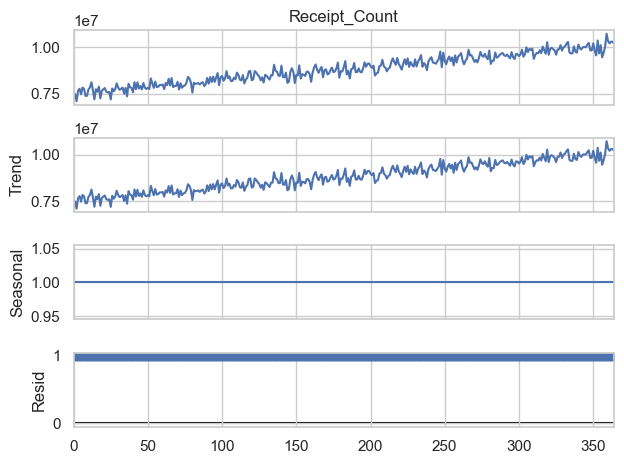

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['Receipt_Count'], model='multiplicative', period=1)
result.plot()
plt.show()

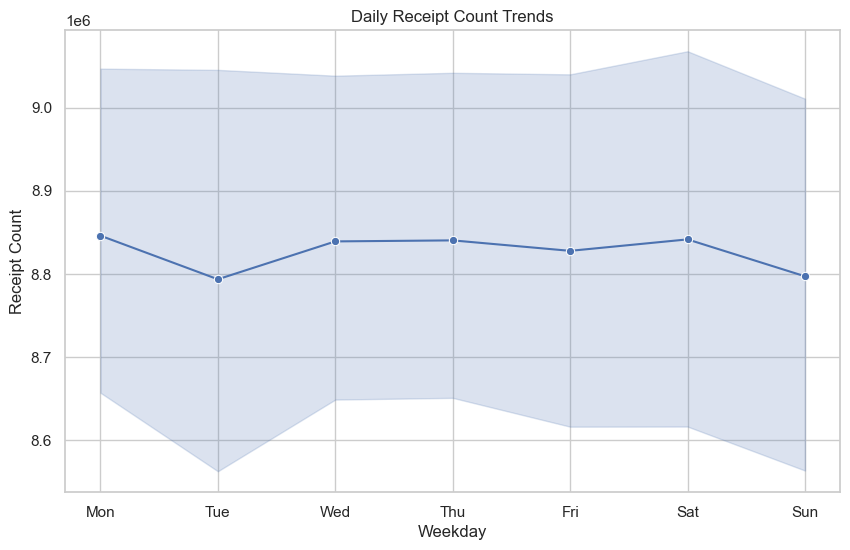

In [37]:
# Plotting daily trends
plt.figure(figsize=(10, 6))
sns.lineplot(x='Weekday', y='Receipt_Count', data=df, marker='o')
plt.title('Daily Receipt Count Trends')
plt.xlabel('Weekday')
plt.ylabel('Receipt Count')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()


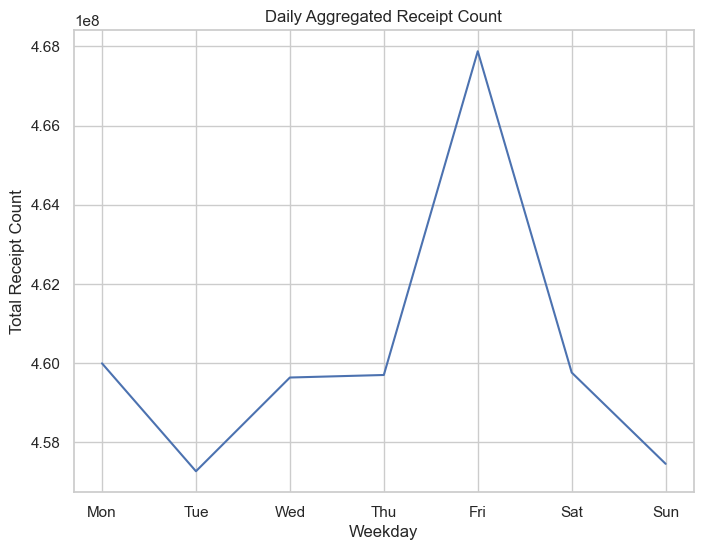

In [38]:
# Aggregate data on a daily basis
daily_receipts = df.groupby('Weekday')['Receipt_Count'].sum()

# Plot daily aggregated data
plt.figure(figsize=(8, 6))
sns.lineplot(x=daily_receipts.index, y=daily_receipts.values, palette='viridis')
plt.title('Daily Aggregated Receipt Count')
plt.xlabel('Weekday')
plt.ylabel('Total Receipt Count')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()


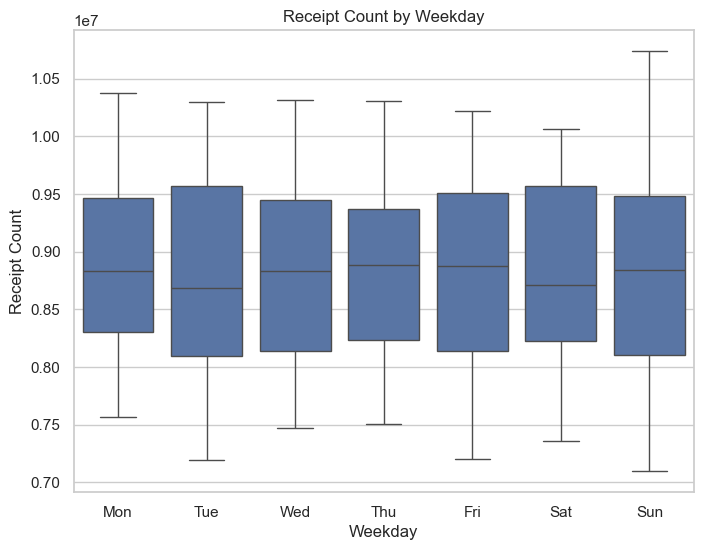

In [39]:
# Box plot to identify outliers on a daily basis
plt.figure(figsize=(8, 6))
sns.boxplot(x='Weekday', y='Receipt_Count', data=df)
plt.title('Receipt Count by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Receipt Count')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()


In [44]:
df = pd.read_csv('data.csv')
df=df.drop(['Unnamed: 0'],axis=1)
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Receipt_Count
0,2021-01-01,7564766
1,2021-01-02,7455524
2,2021-01-03,7095414
3,2021-01-04,7666163
4,2021-01-05,7771289


## Linear Regression

In [45]:

df.set_index('Date',inplace=True)
df.head()

,Receipt_Count
Date,
2021-01-01,7564766
2021-01-02,7455524
2021-01-03,7095414
2021-01-04,7666163
2021-01-05,7771289


In [4]:
from sklearn.preprocessing import MinMaxScaler
target_variable = 'Receipt_Count'
data = df[[target_variable]]

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define the number of previous time steps to use for prediction
look_back = 100

# Create input features and target variable
x, y = [], []
for i in range(look_back, len(scaled_data)):
    x.append(scaled_data[i - look_back:i, 0])
    y.append(scaled_data[i, 0])

x, y = np.array(x), np.array(y)

In [5]:


class LinearRegression:
    def __init__(self):
        self.coefficients = None
        self.intercept = None

    def fit(self, x, y):
        x = self._transform_x(x)
        y = self._transform_y(y)

        betas = self._estimate_coefficients(x, y)

        self.intercept = betas[0]
        self.coefficients = betas[1:]

    def predict(self, x):
        predictions = []
        for values in x:
            pred = np.multiply(values, self.coefficients)
            pred = sum(pred)
            pred += self.intercept
            predictions.append(pred)

        return predictions

    def r2_score(self, y_true, y_pred):
        y_values = y_true
        y_average = np.average(y_values)

        residual_sum_of_squares = 0
        total_sum_of_squares = 0

        for i in range(len(y_values)):
            residual_sum_of_squares += (y_values[i] - y_pred[i])**2
            total_sum_of_squares += (y_values[i] - y_average)**2

        return 1 - (residual_sum_of_squares/total_sum_of_squares)

    def _transform_x(self, x):
        ones_column = np.ones((x.shape[0], 1))
        return np.hstack((ones_column, x))

    def _transform_y(self, y):
        return y

    def _estimate_coefficients(self, x, y):
        xT = x.transpose()
        inversed = np.linalg.inv(xT.dot(x))
        coefficients = inversed.dot(xT).dot(y)
        return coefficients


In [6]:
lr = LinearRegression()
# fit our LR to our data
lr.fit(x, y)


In [7]:
# Create input sequences for 2022
x_2022 = scaled_data[-look_back:].reshape(1, -1)  # Use the last 60 days of available data as initial input for 2022

# Generate forecasts for 2022 (assuming 365 days in a year)
forecasted_values_2022 = []

for _ in range(365):
    # Predict the next day
    next_day_prediction = lr.predict(x_2022)
    
    # Append the prediction to the forecasted values list
    forecasted_values_2022.append(next_day_prediction[0])
    
    # Update the input sequence: remove the first element and append the prediction
    x_2022 = np.append(x_2022[:, 1:], [next_day_prediction], axis=1)

# Inverse transform the forecasted values to get the actual receipt counts
forecasted_values_2022 = scaler.inverse_transform(np.array(forecasted_values_2022).reshape(-1, 1))

# Create a date range for 2022
dates_2022 = pd.date_range(start='2022-01-01', end='2022-12-31')

# Create a DataFrame for 2022 predictions
predictions_2022_df = pd.DataFrame(data=forecasted_values_2022, index=dates_2022, columns=['Predictions'])

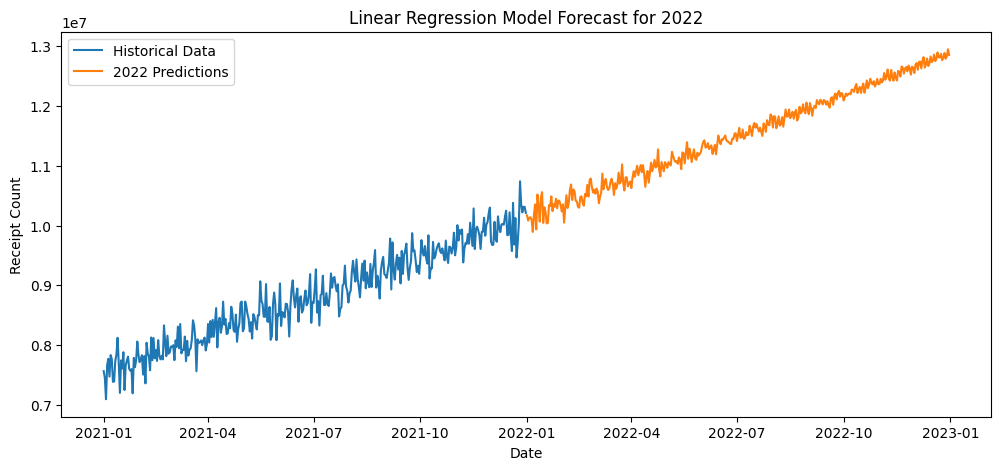

In [8]:
# Plot the results
plt.figure(figsize=(12, 5))
plt.title('Linear Regression Model Forecast for 2022')
plt.xlabel('Date')
plt.ylabel('Receipt Count')
plt.plot(data.index, df[target_variable], label='Historical Data')
plt.plot(predictions_2022_df.index, predictions_2022_df['Predictions'], label='2022 Predictions')
plt.legend()
plt.show()

In [9]:
import pickle

# Save the model to a file
with open('linear_regression_model.pkl', 'wb') as model_file:
    pickle.dump(lr, model_file)

print('Model saved successfully.')


Model saved successfully.


MSE: 0.008422918462318107, rmse: 0.09177645919470911


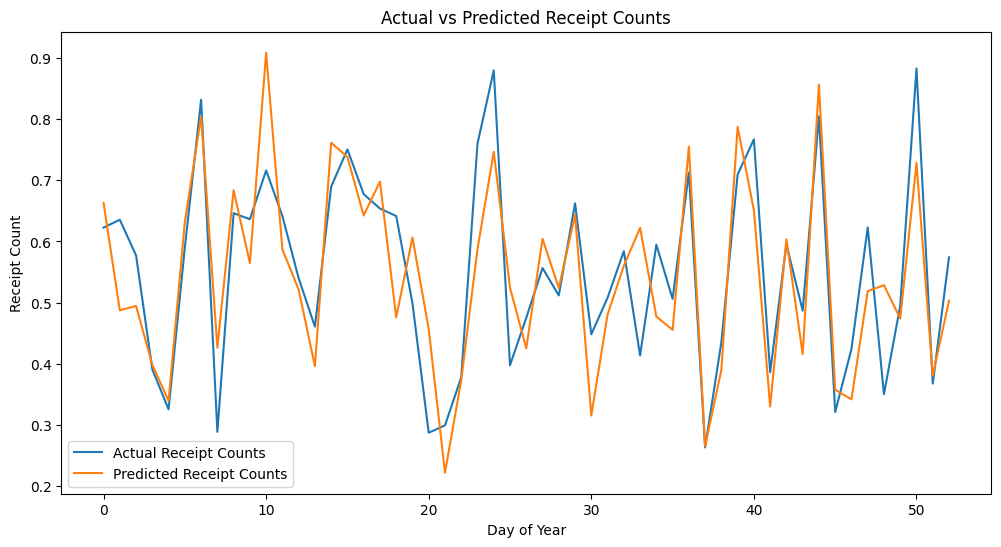

In [10]:
# Split the data into training and testing sets (80% training, 20% testing)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
# Calculate Mean Squared Error (MSE)
mse = np.mean((predictions - y_test) ** 2)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'MSE: {mse}, rmse: {rmse}')
# Plot actual and predicted receipt counts for the test set
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)),y_test, label='Actual Receipt Counts', linestyle='-')
plt.plot(predictions, label='Predicted Receipt Counts', linestyle='-')
plt.xlabel('Day of Year')
plt.ylabel('Receipt Count')
plt.title('Actual vs Predicted Receipt Counts')
plt.legend()
plt.show()

Linear Regression gave somewhat good predictions we can use better models to give better predictions

## LSTM

In [11]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [12]:
data = df.copy()
data.head()

,Receipt_Count
Date,
2021-01-01,7564766
2021-01-02,7455524
2021-01-03,7095414
2021-01-04,7666163
2021-01-05,7771289


In [13]:
class MinMaxScalerCustom:
    def __init__(self, feature_range=(0, 1)):
        self.feature_range = feature_range

    def fit(self, data):
        self.data_min = np.min(data)
        self.data_max = np.max(data)
        self.scale = (self.feature_range[1] - self.feature_range[0]) / (self.data_max - self.data_min)
        self.min_val = self.feature_range[0] - self.data_min * self.scale
        return self

    def transform(self, data):
        scaled_data = data * self.scale + self.min_val
        return scaled_data
    
    def inverse_transform(self, scaled_data):
        data = (scaled_data - self.feature_range[0]) / (self.feature_range[1] - self.feature_range[0])
        data = data / self.scale + self.data_min
        return data

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [14]:
y_ = df['Receipt_Count'].values
y_ = y_.reshape(-1, 1)
custom_scaler = MinMaxScalerCustom(feature_range=(0, 1))
scaled_data = custom_scaler.fit_transform(y_)

In [15]:
Receipt_Count = data['Receipt_Count']
values = Receipt_Count.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScalerCustom(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [16]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [17]:
# LSTM Model
model = keras.Sequential()
model.add(layers.LSTM(25, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(25, return_sequences=False))
model.add(layers.Dense(12))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 25)            2700      
                                                                 
 lstm_1 (LSTM)               (None, 25)                5100      
                                                                 
 dense (Dense)               (None, 12)                312       
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 8125 (31.74 KB)
Trainable params: 8125 (31.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
232/232 [==============================] - 2s 6ms/step - loss: 0.0102
Epoch 2/3
232/232 [==============================] - 1s 6ms/step - loss: 0.0055
Epoch 3/3
232/232 [==============================] - 1s 6ms/step - loss: 0.0059


In [19]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

3/3 [==============================] - 0s 3ms/step


28220.352739726026

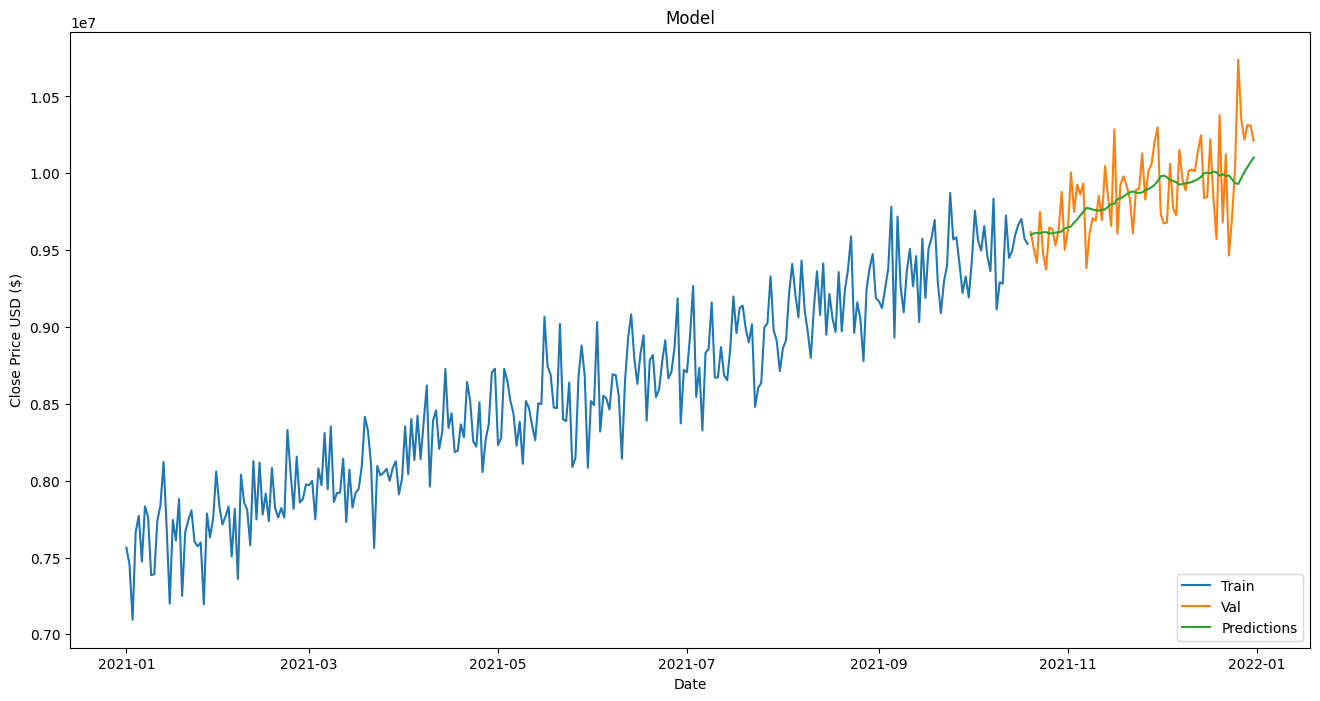

In [20]:
data = data.filter(['Receipt_Count'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Receipt_Count', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [21]:
# Use the last 60 data points from 2021 as input sequences
last_60_days = scaled_data[-60:]

# Create an initial input sequence for 2022
initial_input_2022 = np.array(last_60_days).reshape(1, -1, 1)

In [22]:
# Generate forecasts for 2022
forecasted_values_2022 = []

for _ in range(365):  # Assuming you want to forecast for the entire year 2022
    # Predict the next day
    next_day_prediction = model.predict(initial_input_2022)

    # Append the prediction to the forecasted values list
    forecasted_values_2022.append(next_day_prediction[0, 0])

    # Update the input sequence: remove the first element and append the prediction
    initial_input_2022 = np.append(initial_input_2022[:, 1:, :], next_day_prediction.reshape(1, 1, 1), axis=1)

# Inverse transform the forecasted values to get the actual receipt counts
forecasted_values_2022 = scaler.inverse_transform(np.array(forecasted_values_2022).reshape(-1, 1))

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


In [23]:
from datetime import datetime
start_date = datetime(2022, 1, 1)
end_date = datetime(2022, 12, 31)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
prediction_data = pd.DataFrame({'Date': date_range})
prediction_data.set_index('Date',inplace=True)
prediction_data['Receipt_Count']=forecasted_values_2022
prediction_data.head()

,Receipt_Count
Date,
2022-01-01,10122891.75
2022-01-02,10134192.75
2022-01-03,10140209.25
2022-01-04,10143114.75
2022-01-05,10144204.25


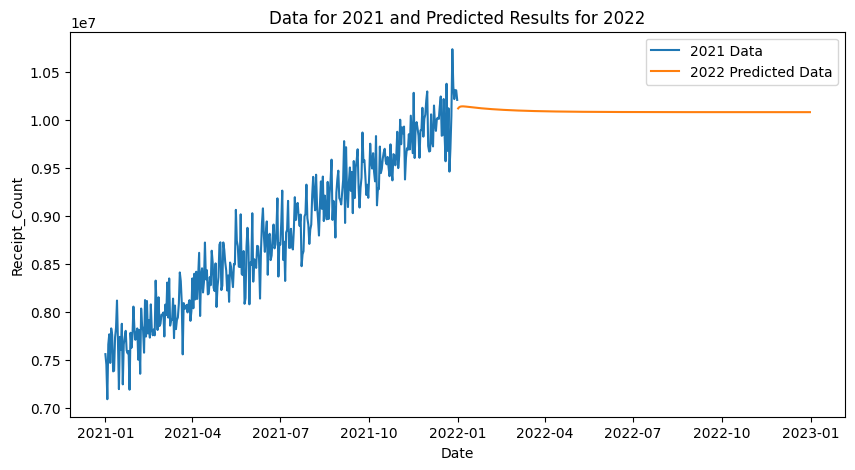

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['Receipt_Count'], label='2021 Data')
plt.plot(prediction_data.index,prediction_data['Receipt_Count'], label = '2022 Predicted Data')
plt.xlabel('Date')
plt.ylabel('Receipt_Count')
plt.title('Data for 2021 and Predicted Results for 2022')
plt.legend()

LSTM require more data to give good predictions